## 이미 rembg를 통해서 배경을 제거한 의류 이미지에서 마스킹이 제대로 안되는 문제를 발견해 개선방향 탐구

In [1]:
import os, sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
catvton_dir = os.path.join(parent_dir, "CatVTON")
if catvton_dir not in sys.path:
    sys.path.insert(0, catvton_dir)

# Set the project root directory
project_root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

In [2]:
import os
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download
from model.cloth_masker import AutoMasker, vis_mask
from diffusers.image_processor import VaeImageProcessor
from utils import init_weight_dtype, resize_and_crop, resize_and_padding
from tqdm.notebook import tqdm
import torch
import PIL
# Download the CatVTON repository
repo_path = snapshot_download(repo_id="zhengchong/CatVTON")

# Initialize the AutoMasker with the correct checkpoint paths and device configuration
automasker = AutoMasker(
    densepose_ckpt=os.path.join(repo_path, "DensePose"),
    schp_ckpt=os.path.join(repo_path, "SCHP"),
    device='cuda'
)
mask_processor = VaeImageProcessor(vae_scale_factor=8, do_normalize=False, do_binarize=True, do_convert_grayscale=True)

c:\Users\coldbrew\.conda\envs\vton\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\coldbrew\VTON-project\CatVTON\model\SCHP\__init__.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location='cpu')['state

### 이미지 2개만 가져와서 상의, 하의에 대해서 처리하고 시각화하기

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import cv2
%matplotlib inline

# def vis_image(image, mask, shape, title=None):
#     # OpenCV는 (width, height) 순서로 크기를 받음.
#     resized_image = cv2.resize(image, (shape[1], shape[0]))
#     # mask가 binary라면 0과 1로 되어있으므로, 먼저 uint8로 변환 후 resizing
#     resized_mask = cv2.resize(mask.astype(np.uint8), (shape[1], shape[0]))
#     resized_mask = resized_mask.astype(bool)
    
#     # Create an RGBA version of the image
#     rgba_image = np.zeros((shape[0], shape[1], 4), dtype=np.uint8)
#     rgba_image[..., :3] = resized_image
#     rgba_image[..., 3] = 255

#     # Create an RGBA version of the mask with 70% transparency
#     rgba_mask = np.zeros((shape[0], shape[1], 4), dtype=np.uint8)
#     rgba_mask[..., 0] = 255  # Red channel
#     rgba_mask[..., 3] = 178  # Alpha channel (70% transparency)

#     # Overlay the mask on the image
#     overlay = np.where(resized_mask[..., None], rgba_mask, rgba_image)

#     fig, ax = plt.subplots()
#     ax.imshow(overlay)
#     ax.axis('off')
#     if title:
#         ax.set_title(title)
#     plt.show()
#     plt.close(fig)
def vis_image(image, title=None):
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

## 기존 방식

  0%|          | 0/195 [00:00<?, ?it/s]

c:\Users\coldbrew\.conda\envs\vton\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


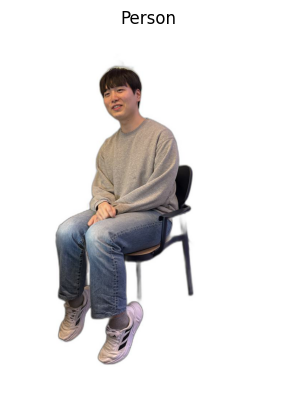

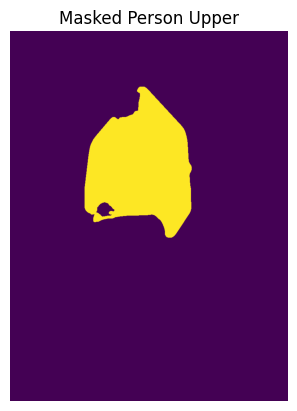

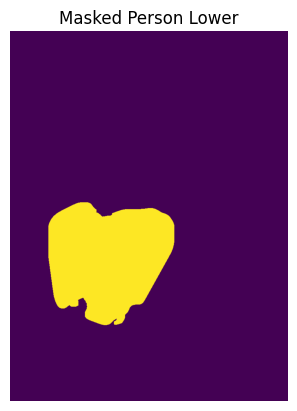

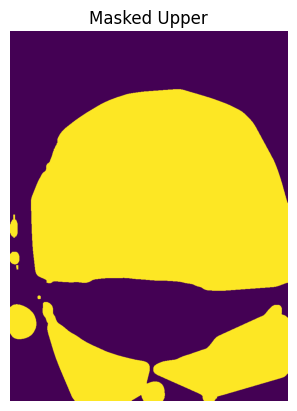

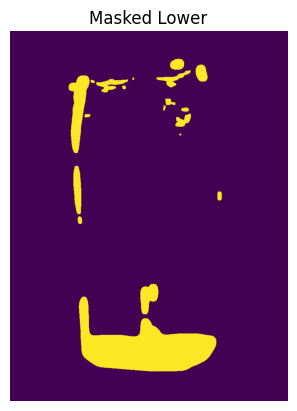

In [4]:
# rembg 된 이미지 가져올 경로
masked_person_path = os.path.join(project_root_dir, "data", "dataset", "image")
masked_upper_path = os.path.join(project_root_dir, "data", "dataset", "cloth", "upper")
masked_lower_path = os.path.join(project_root_dir, "data", "dataset", "cloth", "lower")

# 저장할 경로
masked_dest_person = os.path.join(project_root_dir, "data","dataset", "masked_image")
masked_dest_cloth_upper = os.path.join(project_root_dir, "data","dataset", "cloth", "masked_upper")
masked_dest_cloth_lower = os.path.join(project_root_dir, "data","dataset", "cloth", "masked_lower")

# if not os.path.exists(masked_dest_person):
#     os.makedirs(masked_dest_person)
# if not os.path.exists(masked_dest_cloth_upper):
#     os.makedirs(masked_dest_cloth_upper)
# if not os.path.exists(masked_dest_cloth_lower):
#     os.makedirs(masked_dest_cloth_lower)


for person_path, upper_path, lower_path in tqdm(zip(os.listdir(masked_person_path), os.listdir(masked_upper_path), os.listdir(masked_lower_path)), total=len(os.listdir(masked_person_path))):
    person_img = PIL.Image.open(os.path.join(masked_person_path, person_path))
    upper_img = PIL.Image.open(os.path.join(masked_upper_path, upper_path))
    lower_img = PIL.Image.open(os.path.join(masked_lower_path, lower_path))
    
    masked_person_upper = automasker(person_img, "upper")['mask']
    masked_person_lower = automasker(person_img, "lower")['mask']
    masked_upper = automasker(upper_img, "upper")['mask']
    masked_lower = automasker(lower_img, "lower")['mask']
    

    vis_image(person_img, "Person")
    vis_image(masked_person_upper, "Masked Person Upper")
    vis_image(masked_person_lower, "Masked Person Lower")
    vis_image(masked_upper, "Masked Upper")
    vis_image(masked_lower, "Masked Lower")

    break
    # masked_person.save(os.path.join(masked_dest_person, person_path))
    # masked_upper.save(os.path.join(masked_dest_cloth_upper, upper_path))
    # masked_lower.save(os.path.join(masked_dest_cloth_lower, lower_path))

## rembg -> 4x down&upsampling -> mask

  0%|          | 0/195 [00:00<?, ?it/s]

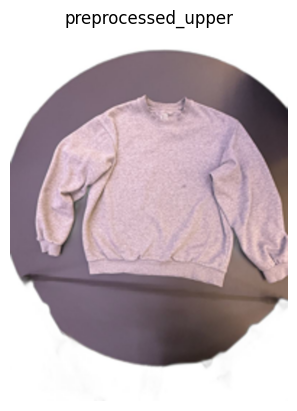

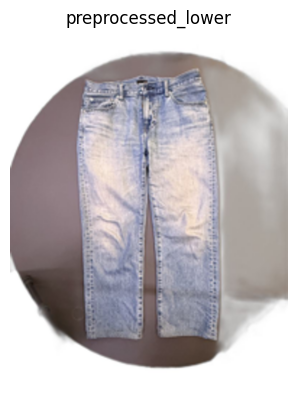

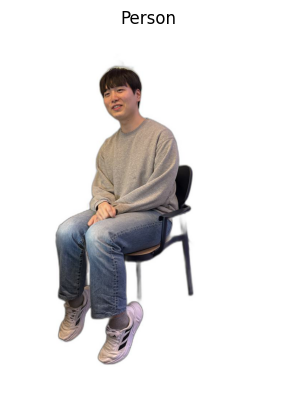

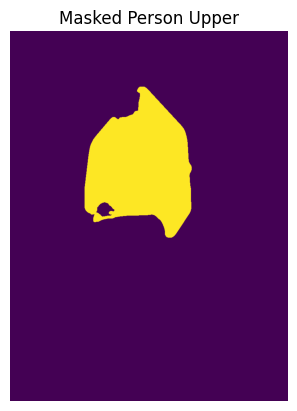

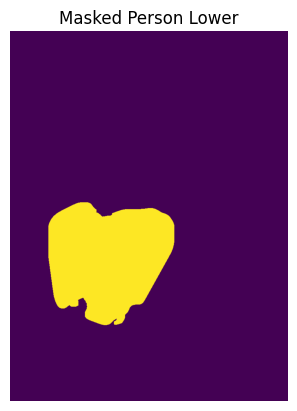

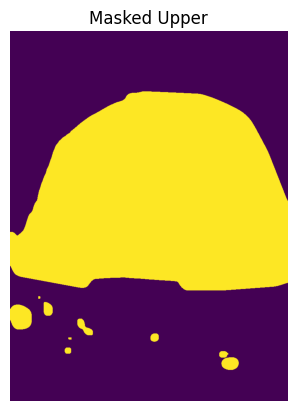

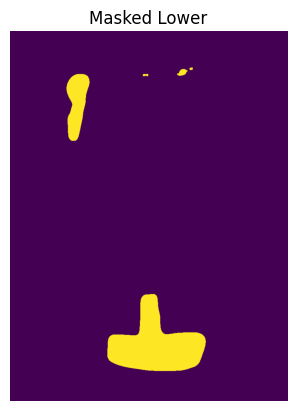

In [5]:
# rembg 된 이미지 가져올 경로
masked_person_path = os.path.join(project_root_dir, "data", "dataset", "image")
masked_upper_path = os.path.join(project_root_dir, "data", "dataset", "cloth", "upper")
masked_lower_path = os.path.join(project_root_dir, "data", "dataset", "cloth", "lower")

# 저장할 경로
masked_dest_person = os.path.join(project_root_dir, "data","dataset", "masked_image")
masked_dest_cloth_upper = os.path.join(project_root_dir, "data","dataset", "cloth", "masked_upper")
masked_dest_cloth_lower = os.path.join(project_root_dir, "data","dataset", "cloth", "masked_lower")

# if not os.path.exists(masked_dest_person):
#     os.makedirs(masked_dest_person)
# if not os.path.exists(masked_dest_cloth_upper):
#     os.makedirs(masked_dest_cloth_upper)
# if not os.path.exists(masked_dest_cloth_lower):
#     os.makedirs(masked_dest_cloth_lower)


for person_path, upper_path, lower_path in tqdm(zip(os.listdir(masked_person_path), os.listdir(masked_upper_path), os.listdir(masked_lower_path)), total=len(os.listdir(masked_person_path))):
    person_img = PIL.Image.open(os.path.join(masked_person_path, person_path))
    upper_img = PIL.Image.open(os.path.join(masked_upper_path, upper_path))
    lower_img = PIL.Image.open(os.path.join(masked_lower_path, lower_path))
    
    masked_person_upper = automasker(person_img, "upper")['mask']
    masked_person_lower = automasker(person_img, "lower")['mask']

    # 의류 이미지의 경우 4배 축소 후 bicubic으로 확대
    down_upper = upper_img.resize((upper_img.width // 4, upper_img.height // 4), PIL.Image.BICUBIC)
    up_upper = down_upper.resize((upper_img.width, upper_img.height), PIL.Image.BICUBIC)
    
    down_lower = lower_img.resize((lower_img.width // 4, lower_img.height // 4), PIL.Image.BICUBIC)
    up_lower = down_lower.resize((lower_img.width, lower_img.height), PIL.Image.BICUBIC)
    
    vis_image(up_upper,"preprocessed_upper")
    vis_image(up_lower,"preprocessed_lower")
    masked_upper = automasker(up_upper, "upper")['mask']
    masked_lower = automasker(up_lower, "lower")['mask']
 

    vis_image(person_img, "Person")
    vis_image(masked_person_upper, "Masked Person Upper")
    vis_image(masked_person_lower, "Masked Person Lower")
    vis_image(masked_upper, "Masked Upper")
    vis_image(masked_lower, "Masked Lower")

    break
    # masked_person.save(os.path.join(masked_dest_person, person_path))
    # masked_upper.save(os.path.join(masked_dest_cloth_upper, upper_path))
    # masked_lower.save(os.path.join(masked_dest_cloth_lower, lower_path))

## original img -> 4x down&upsampling -> mask -> rembg

  0%|          | 0/195 [00:00<?, ?it/s]

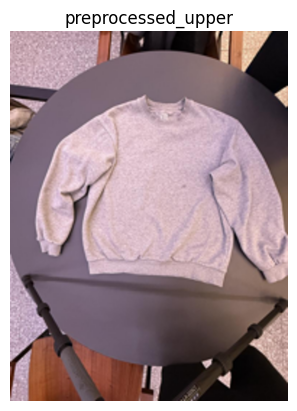

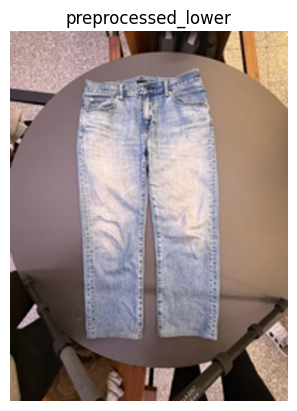

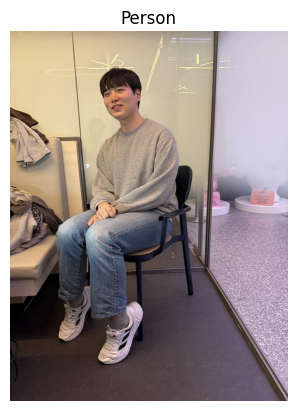

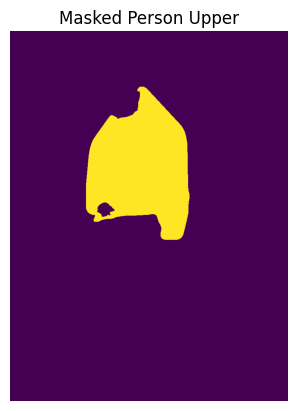

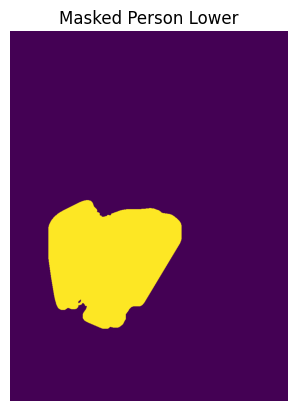

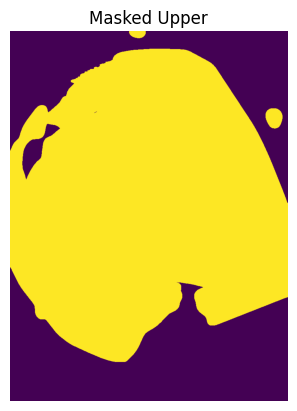

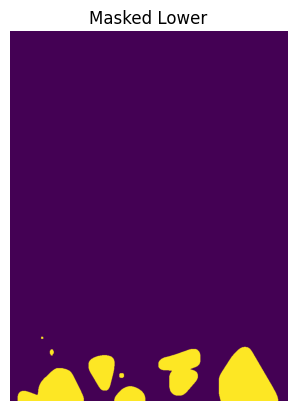

In [6]:
person_dir_path = os.path.join(project_root_dir, "data", "dataset_origin", "image")
upper_dir_path = os.path.join(project_root_dir, "data", "dataset_origin", "cloth", "upper")
lower_dir_path = os.path.join(project_root_dir, "data", "dataset_origin", "cloth", "lower")


for person, upper, lower in tqdm(zip(os.listdir(person_dir_path), os.listdir(upper_dir_path), os.listdir(lower_dir_path)), total=len(os.listdir(masked_person_path))):
    person_img = PIL.Image.open(os.path.join(person_dir_path, person))
    upper_img = PIL.Image.open(os.path.join(upper_dir_path, upper))
    lower_img = PIL.Image.open(os.path.join(lower_dir_path, lower))
    
    masked_person_upper = automasker(person_img, "upper")['mask']
    masked_person_lower = automasker(person_img, "lower")['mask']

    # 의류 이미지의 경우 4배 축소 후 bicubic으로 확대
    down_upper = upper_img.resize((upper_img.width // 4, upper_img.height // 4), PIL.Image.BICUBIC)
    up_upper = down_upper.resize((upper_img.width, upper_img.height), PIL.Image.BICUBIC)
    
    down_lower = lower_img.resize((lower_img.width // 4, lower_img.height // 4), PIL.Image.BICUBIC)
    up_lower = down_lower.resize((lower_img.width, lower_img.height), PIL.Image.BICUBIC)
    
    vis_image(up_upper,"preprocessed_upper")
    vis_image(up_lower,"preprocessed_lower")
    masked_upper = automasker(up_upper, "upper")['mask']
    masked_lower = automasker(up_lower, "lower")['mask']
 

    vis_image(person_img, "Person")
    vis_image(masked_person_upper, "Masked Person Upper")
    vis_image(masked_person_lower, "Masked Person Lower")
    vis_image(masked_upper, "Masked Upper")
    vis_image(masked_lower, "Masked Lower")

    break
    # masked_person.save(os.path.join(masked_dest_person, person_path))
    # masked_upper.save(os.path.join(masked_dest_cloth_upper, upper_path))
    # masked_lower.save(os.path.join(masked_dest_cloth_lower, lower_path))

## original img -> mask -> rembg

  0%|          | 0/195 [00:00<?, ?it/s]

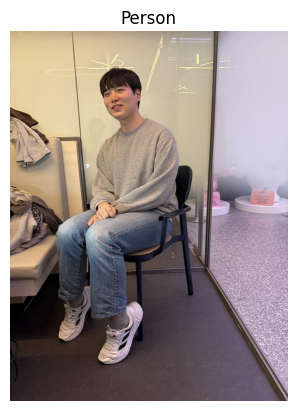

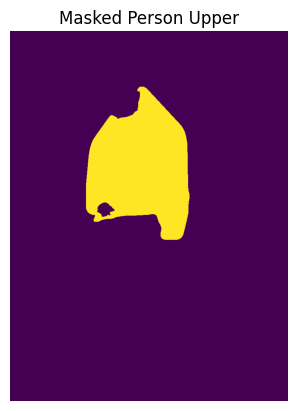

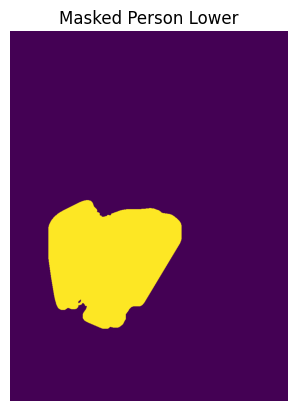

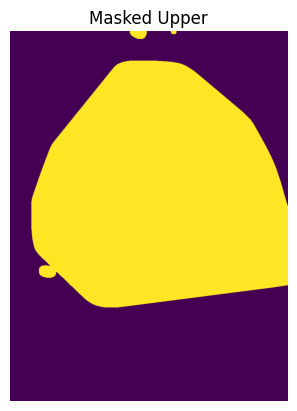

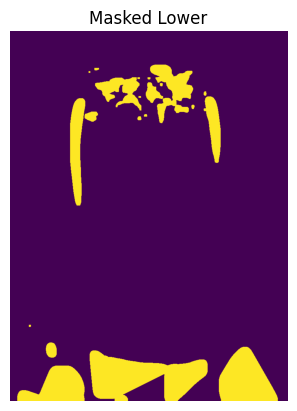

In [7]:
person_dir_path = os.path.join(project_root_dir, "data", "dataset_origin", "image")
upper_dir_path = os.path.join(project_root_dir, "data", "dataset_origin", "cloth", "upper")
lower_dir_path = os.path.join(project_root_dir, "data", "dataset_origin", "cloth", "lower")


for person, upper, lower in tqdm(zip(os.listdir(person_dir_path), os.listdir(upper_dir_path), os.listdir(lower_dir_path)), total=len(os.listdir(masked_person_path))):
    person_img = PIL.Image.open(os.path.join(person_dir_path, person))
    upper_img = PIL.Image.open(os.path.join(upper_dir_path, upper))
    lower_img = PIL.Image.open(os.path.join(lower_dir_path, lower))
    
    masked_person_upper = automasker(person_img, "upper")['mask']
    masked_person_lower = automasker(person_img, "lower")['mask']
    
    masked_upper = automasker(upper_img, "upper")['mask']
    masked_lower = automasker(lower_img, "lower")['mask']

    vis_image(person_img, "Person")
    vis_image(masked_person_upper, "Masked Person Upper")
    vis_image(masked_person_lower, "Masked Person Lower")
    vis_image(masked_upper, "Masked Upper")
    vis_image(masked_lower, "Masked Lower")

    break
    # masked_person.save(os.path.join(masked_dest_person, person_path))
    # masked_upper.save(os.path.join(masked_dest_cloth_upper, upper_path))
    # masked_lower.save(os.path.join(masked_dest_cloth_lower, lower_path))

## Origin -> SAM2 써보기 
- sam 가상환경 만들어서 사용

In [8]:
# !git clone https://github.com/facebookresearch/sam2.git && cd sam2
# !pip install -e .

In [9]:
# cd checkpoints && \
# ./download_ckpts.sh && \
# cd ..
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# !pip install huggingface_hub

In [10]:
import torch
import os, sys
print(torch.cuda.is_available())

True


In [12]:
# project_root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
# sam_root = os.path.join(project_root_dir,"sam2")
# sys.path.insert(0, sam_root)

# import torch
# from sam2.build_sam import build_sam2
# from sam2.sam2_image_predictor import SAM2ImagePredictor
# import PIL
# import numpy as np

# checkpoint = os.path.join(sam_root,"checkpoints\sam2.1_hiera_large.pt")
# model_cfg = os.path.join(sam_root,"checkpoints\sam2.1_hiera_l.yaml")
# predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))
# test_image_path = os.path.join(project_root_dir, "data", "dataset_origin", "cloth","lower", "00000.jpg")

# test_image = PIL.Image.open(test_image_path).convert("RGB")
# test_image_np = np.array(test_image)


# with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
#     predictor.set_image(test_image_np)
#     h, w = test_image_np.shape[:2]
#     # 전체 이미지 영역을 bounding box 프롬프트로 지정
#     bbox = np.array([[0, 0, w, h]])
#     masks, scores, logits = predictor.predict(box=bbox)


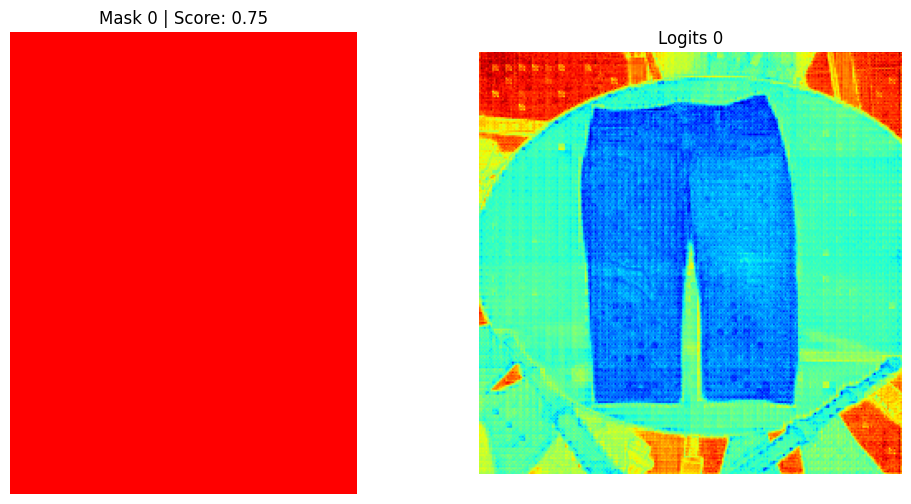

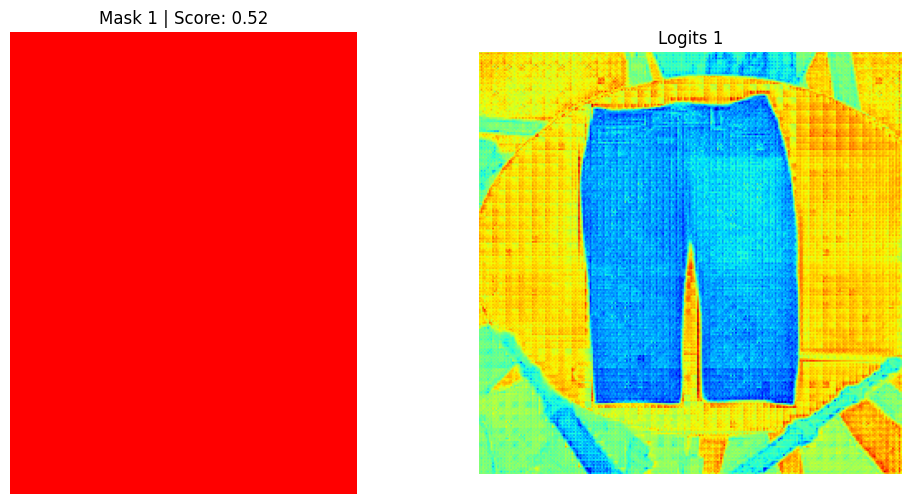

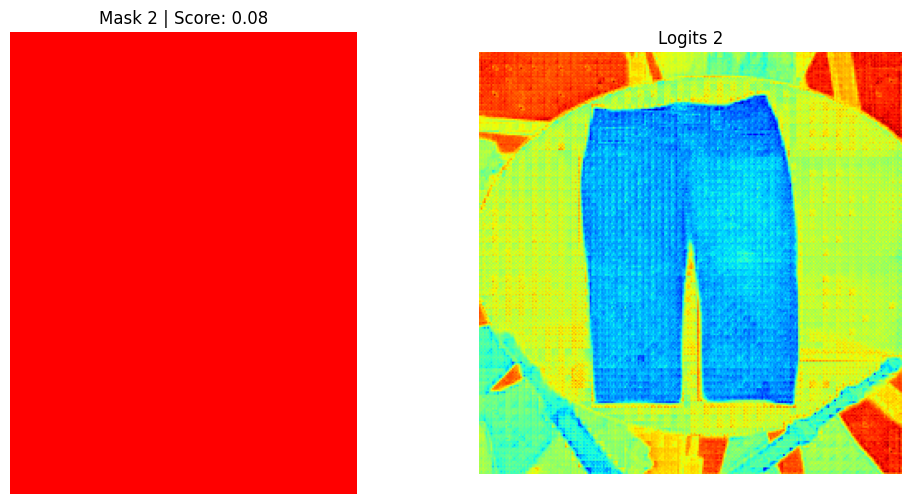

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# masks: (N, H, W), scores: (N,), logits: (N, H, W)
num_masks = masks.shape[0]

for i in range(num_masks):
    mask = masks[i]  # 이진 마스크 (0/1)
    score = scores[i]
    logits_map = logits[i]  # 낮은 해상도 logits 또는 원본 해상도에 맞게 조정된 것

    # 원본 이미지와 마스크 오버레이
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # 왼쪽: 원본 이미지 + 마스크 오버레이
    ax[0].imshow(test_image_np)
    # 빨간색 색상 오버레이 생성 (mask 값 1인 부분에만 색칠)
    red_overlay = np.zeros_like(test_image_np, dtype=np.uint8)
    red_overlay[..., 0] = 255  # red channel
    ax[0].imshow(red_overlay, alpha=mask * 0.5)
    ax[0].set_title(f"Mask {i} | Score: {score:.2f}")
    ax[0].axis("off")
    
    # 오른쪽: logits heatmap 시각화
    ax[1].imshow(logits_map, cmap="jet")
    ax[1].set_title(f"Logits {i}")
    ax[1].axis("off")
    
    plt.show()

In [3]:
import os
import PIL.Image
import numpy as np
from tqdm import tqdm
import torch

from sam2.sam2_image_predictor import SAM2ImagePredictor

# 기존 경로
person_dir_path = os.path.join(project_root_dir, "data", "dataset_origin", "image")
upper_dir_path = os.path.join(project_root_dir, "data", "dataset_origin", "cloth", "upper")
lower_dir_path = os.path.join(project_root_dir, "data", "dataset_origin", "cloth", "lower")

# SAM2 모델 로드 (SAM2-Hiera-Large 사용)
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

for person, upper, lower in tqdm(zip(os.listdir(person_dir_path), os.listdir(upper_dir_path), os.listdir(lower_dir_path)), total=len(os.listdir(person_dir_path))):
    person_img = PIL.Image.open(os.path.join(person_dir_path, person))
    upper_img = PIL.Image.open(os.path.join(upper_dir_path, upper))
    lower_img = PIL.Image.open(os.path.join(lower_dir_path, lower))
    
    # 기존 automasker로 사람과 상의에 대해 마스크 생성
    masked_person_upper = automasker(person_img, "upper")['mask']
    masked_person_lower = automasker(person_img, "lower")['mask']
    masked_upper = automasker(upper_img, "upper")['mask']
    
    # SAM2를 사용하여 하의 마스크 생성
    lower_np = np.array(lower_img)
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        predictor.set_image(lower_np)
        w, h = lower_img.size
        # 하의의 하단 절반 영역을 bounding box로 지정 ([x1, y1, x2, y2])
        bbox = np.array([[0, h * 0.5, w, h]])
        masks, scores, _ = predictor.predict(box=bbox)
        # 예측된 마스크 중 최고 점수를 가진 마스크 선택
        idx = np.argmax(scores)
        masked_lower = masks[idx].astype(np.uint8)
    
    vis_image(person_img, "Person")
    vis_image(masked_person_upper, "Masked Person Upper")
    vis_image(masked_person_lower, "Masked Person Lower")
    vis_image(masked_upper, "Masked Upper")
    vis_image(masked_lower, "Masked Lower")
    
    break  # 테스트를 위해 첫 이미지에서 중지

ModuleNotFoundError: No module named 'huggingface_hub'